# 1.1 Data Visualization


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('milestone1/dataset/cases_train.csv')
df_location = pd.read_csv('milestone1/dataset/location.csv')

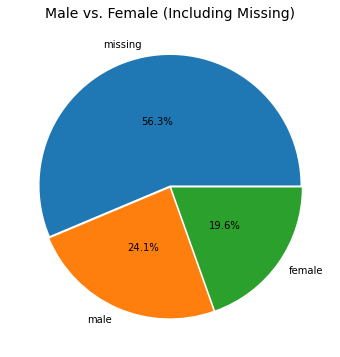

In [2]:
#Exploring sex
df['sex'] = df['sex'].fillna('missing')

sex = df['sex'].value_counts()

pie, ax = plt.subplots(figsize=[10,6])
labels = sex.keys()
plt.pie(x=sex, autopct="%.1f%%", explode=[0.01]*len(sex), labels=labels, pctdistance=0.5)
plt.title("Male vs. Female (Including Missing)", fontsize=14);

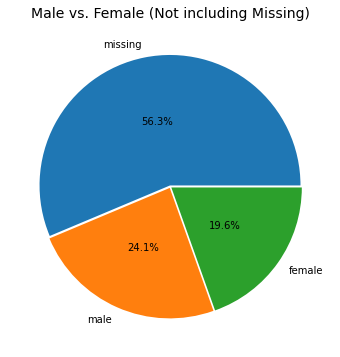

In [3]:
#Take a look at only rows where a sex was provided
sexdf = df[~df['sex'].isna()]
sex = sexdf['sex'].value_counts() #df with no missing vals for sex

pie, ax = plt.subplots(figsize=[10,6])
labels = sex.keys()
plt.pie(x=sex, autopct="%.1f%%", explode=[0.01]*len(sex), labels=labels, pctdistance=0.5)
plt.title("Male vs. Female (Not including Missing)", fontsize=14);

In [4]:
#top 10 countries
countries = df['country'].value_counts().head(10) 
countries

India             212411
Peru               57305
Germany            33009
Philippines        11521
Colombia           11464
Argentina           7948
Mexico              5149
Belgium             5145
United Kingdom      4289
Czech Republic      3381
Name: country, dtype: int64

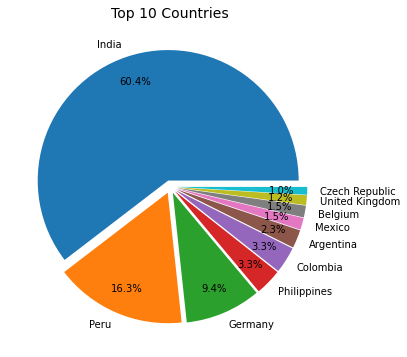

In [5]:
#Exploring Top 10 countries
pie, ax = plt.subplots(figsize=[10,6])
labels = countries.keys()
plt.pie(x=countries, autopct="%.1f%%", explode=[0.05]*len(countries), labels=labels, pctdistance=0.8)
plt.title("Top 10 Countries", fontsize=14);

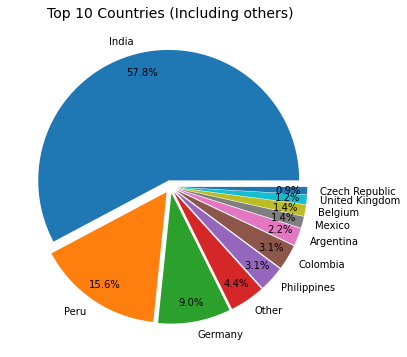

In [6]:
#Aggregating countries not in top 10 into category called other

country_list = list(countries.keys())

def fix_values(row):
        if row['country'] not in country_list:
            row['country'] = 'Other'
        return row 

df_other = df.apply(fix_values, axis=1)
countries_other = df_other['country'].value_counts()

pie, ax = plt.subplots(figsize=[10,6])
labels = countries_other.keys()
plt.pie(x=countries_other, autopct="%.1f%%", explode=[0.05]*len(countries_other), labels=labels, pctdistance=0.85)
plt.title("Top 10 Countries (Including others)", fontsize=14);

In [7]:
#Data visualization for dates
#Cleaning dates that have a range by taking the earlier date

def split_date(datestr):
    if datestr == np.nan:
        return np.nan
    elif '-' in str(datestr):
        
        div = datestr.split('-')[0] #take the first date
#         print(f'the string was {datestr} the split is {div}')
        return div
    else:
        return datestr


df['date_confirmation'] = df['date_confirmation'].apply(split_date)
meandate = pd.to_datetime(df.date_confirmation).mean().date()
the_date = str(meandate.day) + '.' + str(meandate.month) + '.' + str(meandate.year)
df['date_confirmation'] = df['date_confirmation'].fillna(the_date) # fill date with mean date
df['date_confirmation'] = pd.to_datetime(df['date_confirmation'].apply(lambda x: str.strip(x)))

In [8]:
#Same thing but doing it on my dataframe with top n countries

df_other['date_confirmation'] = df_other['date_confirmation'].apply(split_date)
meandate = pd.to_datetime(df_other.date_confirmation).mean().date()
the_date = str(meandate.day) + '.' + str(meandate.month) + '.' + str(meandate.year)
df_other['date_confirmation'] = df_other['date_confirmation'].fillna(the_date) # fill date with mean date
df_other['date_confirmation'] = pd.to_datetime(df_other['date_confirmation'].apply(lambda x: str.strip(x)))

In [9]:
country_list = df_other['country'].value_counts().head().keys()

In [10]:
df_lineplot = df_other.apply(fix_values, axis=1)
#pivot so that the values in the column of countries become columns themselves
df_lineplot = df_lineplot.pivot_table(values='outcome', index='date_confirmation',columns='country',aggfunc='count').fillna(0)
df_lineplot = df_lineplot.join(df['date_confirmation'].value_counts()).rename({'date_confirmation':'World'},axis=1) #add the world

reorder = ['World', 'Germany', 'India', 'Peru', 'Philippines', 'Other']
df_lineplot = df_lineplot[reorder]

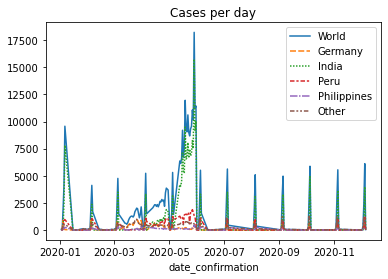

In [11]:
cases_per_day = sns.lineplot(data=df_lineplot).set(title='Cases per day')

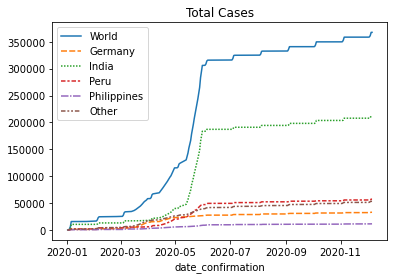

In [12]:
total_cases = sns.lineplot(data=df_lineplot.cumsum()).set(title='Total Cases')

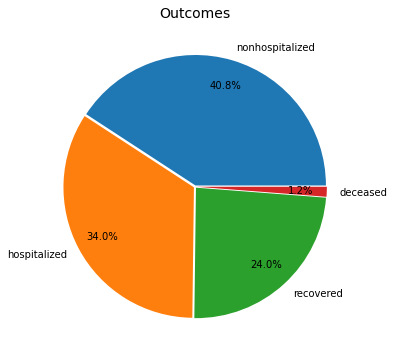

In [14]:
#Visualizing Outcomes
outcomes = df['outcome'].value_counts()
pie, ax = plt.subplots(figsize=[10,6])
labels = outcomes.keys()
plt.pie(x=outcomes, autopct="%.1f%%", explode=[0.01]*len(outcomes), labels=labels, pctdistance=0.8)
plt.title("Outcomes", fontsize=14);

# 1.4: Aggregate the data to the State level for USA

In [15]:
df_US = df_location[df_location['Country_Region'] == 'US']
df_US.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
631,Alabama,US,2020-09-20 04:22:56,32.539527,-86.644082,1673,24,0,1649.0,"Autauga, Alabama, US",2994.505003,1.434549
632,Alabama,US,2020-09-20 04:22:56,30.727750,-87.722071,5047,49,0,4998.0,"Baldwin, Alabama, US",2260.856321,0.970874
633,Alabama,US,2020-09-20 04:22:56,31.868263,-85.387129,830,7,0,823.0,"Barbour, Alabama, US",3362.229604,0.843373
634,Alabama,US,2020-09-20 04:22:56,32.996421,-87.125115,628,10,0,618.0,"Bibb, Alabama, US",2804.322586,1.592357
635,Alabama,US,2020-09-20 04:22:56,33.982109,-86.567906,1542,14,0,1528.0,"Blount, Alabama, US",2666.620551,0.907912


In [18]:
#Group by state
df_state = df_US.groupby(['Country_Region','Province_State']).agg({
    'Lat':'first', #simply take the first lat/lon you see and use it for the state
    'Long_':'first',
    'Confirmed':'sum',
    'Deaths':'sum',
    'Recovered':'sum',
    'Active':'sum',
    'Incidence_Rate':'mean',
    'Case-Fatality_Ratio':'sum' #gets fixed below
}).reset_index(level=0, drop=True) #get rid of USA in index
df_state['Case-Fatality_Ratio'] = df_state['Confirmed']/df_state['Deaths'] #recalculate case-fatality ratio
df_state.head()

,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio
Province_State,,,,,,,,
Alabama,32.539527,-86.644082,144164,2437,0,141727.0,3239.932554,59.156340
Alaska,55.322224,-161.972202,6729,45,0,6684.0,681.806753,149.533333
Arizona,35.394650,-109.489238,212942,5451,0,207491.0,2927.250679,39.064759
Arkansas,34.291452,-91.372773,75160,1181,0,73979.0,2564.972414,63.640982
California,37.646294,-121.892927,783313,15018,0,768295.0,1544.858420,52.158277
